## DS 410 Final Project

Importing libraries, Creating Spark Session, and Reading in the Dataset

In [3]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
from pyspark.sql.functions import lower
from pyspark.sql.types import StructField, StructType, StringType, LongType, IntegerType, FloatType
from pyspark.sql.functions import col, column
from pyspark.sql.functions import expr
from pyspark.sql.functions import split
from pyspark.sql import Row
import xgboost
from xgboost.spark import SparkXGBClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
import pandas as pd
import matplotlib.pyplot as plt
import sparknlp
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType, ArrayType
from nltk.stem.porter import PorterStemmer
import nltk
nltk.download('punkt', quiet=True)
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.functions import vector_to_array
import seaborn as sns
from pyspark.mllib.evaluation import MulticlassMetrics
import numpy as np
from sklearn.metrics import roc_curve, average_precision_score, f1_score, accuracy_score
import random
from pyspark.sql.functions import concat_ws, array_join

In [4]:
ss=SparkSession.builder.master("local").appName("Final_Project").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/02 17:48:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
ss.sparkContext.setCheckpointDir("~/scratch")

In [6]:
schema = StructType([StructField("Sentiment", IntegerType(), nullable = False), \
                     StructField("Title", StringType(), nullable = False), \
                     StructField("Text", StringType(), nullable = False)
                    ])

In [7]:
reviews1 = ss.read.csv("Amazon_reviews_sample.csv", schema = schema, header = True, inferSchema = False)

In [8]:
reviews = reviews1.na.drop()

In [9]:
reviews.printSchema()

root
 |-- Sentiment: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Text: string (nullable = true)



In [10]:
reviews.show(5)

+---------+--------------------+--------------------+
|Sentiment|               Title|                Text|
+---------+--------------------+--------------------+
|        1|Sorry I wasted my...|Neil Gaiman wrote...|
|        1|Loved the prose, ...|Rabbit was not a ...|
|        2|         FASCINATING|Am a Jack Higgins...|
|        1|Little Annie Fann...|This was very, ve...|
|        2|     pressing matter|I have owned Rowe...|
+---------+--------------------+--------------------+
only showing top 5 rows


## EDA

## Distribution of Review Sentiment

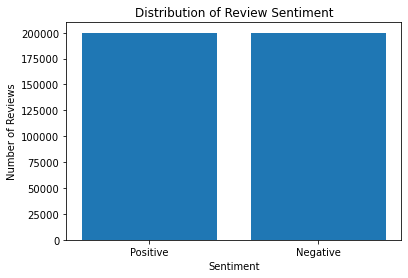

In [11]:
reviews_label = reviews.withColumn("Labeled Sentiment", when(reviews["Sentiment"] == 2, "Positive").when(reviews["Sentiment"] == 1, "Negative"))
sentiment_counts = reviews_label.groupBy("Labeled Sentiment").count()
pandas_sentiment=sentiment_counts.toPandas()
plt.bar(pandas_sentiment["Labeled Sentiment"],pandas_sentiment["count"])
plt.title("Distribution of Review Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()

Removing special characters

In [12]:
from pyspark.sql.functions import regexp_replace
reviews_special_title = reviews_label.withColumn("Title", regexp_replace("Title", "[^a-zA-Z0-9\\s]", ""))
reviews_only_text = reviews_special_title.withColumn("Text", regexp_replace("Text", "[^a-zA-Z0-9\\s]", ""))

Making all words lowercase and splitting by space

In [13]:
reviews_split_title = reviews_label.withColumn("Title", split(lower(reviews_label["Title"]), " "))
reviews_split_title_text = reviews_split_title.withColumn("Text", split(lower(reviews_split_title["Text"]), " "))

Removing stop words, making rdd of title of reviews and text of reviews for positive and negative sentiment

In [14]:
from pyspark.ml.feature import StopWordsRemover
remover = StopWordsRemover(inputCols=["Title", "Text"], outputCols=["Title (No Stop Words)", "Text (No Stop Words)"])
reviews_no_stop_words = remover.transform(reviews_split_title_text)
reviews_title_flat_pos = reviews_no_stop_words.filter(reviews_no_stop_words["Labeled Sentiment"] == "Positive").select("Title (No Stop Words)").rdd.flatMap(lambda x: x).flatMap(lambda x: x)
reviews_text_flat_pos = reviews_no_stop_words.filter(reviews_no_stop_words["Labeled Sentiment"] == "Positive").select("Text (No Stop Words)").rdd.flatMap(lambda x: x).flatMap(lambda x: x)
reviews_title_flat_neg = reviews_no_stop_words.filter(reviews_no_stop_words["Labeled Sentiment"] == "Negative").select("Title (No Stop Words)").rdd.flatMap(lambda x: x).flatMap(lambda x: x)
reviews_text_flat_neg = reviews_no_stop_words.filter(reviews_no_stop_words["Labeled Sentiment"] == "Negative").select("Text (No Stop Words)").rdd.flatMap(lambda x: x).flatMap(lambda x: x)

Concatenate title and reviews rdd for positive and negative sentiment

In [15]:
reviews_pos = reviews_title_flat_pos.union(reviews_text_flat_pos)
reviews_neg = reviews_title_flat_neg.union(reviews_text_flat_neg)

Map words to key-value pairs ex. (word, 1)

In [16]:
reviews_pos_key_val = reviews_pos.map(lambda x: (x, 1))
reviews_neg_key_val = reviews_neg.map(lambda x: (x, 1))

Reduce key-value pairs by key (aggregate counts of words)

In [17]:
reviews_pos_key_val_reduced = reviews_pos_key_val.reduceByKey(lambda x, y: x + y, 4)
reviews_neg_key_val_reduced = reviews_neg_key_val.reduceByKey(lambda x, y: x + y, 4)

Sort aggregated counts of words in descending order

In [18]:
reviews_pos_key_val_sorted = reviews_pos_key_val_reduced.sortBy(lambda pair: pair[1], ascending=False)
reviews_neg_key_val_sorted = reviews_neg_key_val_reduced.sortBy(lambda pair: pair[1], ascending=False)

Get ten most frequent words for title of reviews and text of reviews

In [19]:
reviews_pos_key_val_sorted_top_ten = reviews_pos_key_val_sorted.take(10)
reviews_neg_key_val_sorted_top_ten  = reviews_neg_key_val_sorted.take(10)

## Bar graph of ten most frequent words in positive reviews

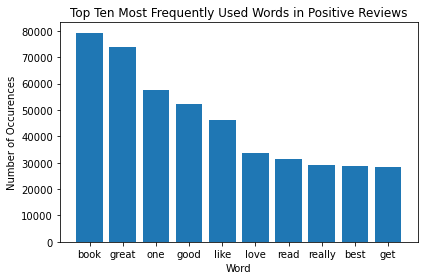

In [20]:
plt.bar([item[0] for item in reviews_pos_key_val_sorted_top_ten], [item[1] for item in reviews_pos_key_val_sorted_top_ten])
plt.xlabel("Word")
plt.ylabel("Number of Occurences")
plt.title("Top Ten Most Frequently Used Words in Positive Reviews")
plt.tight_layout()
plt.show()

## Bar graph of ten most frequent words in negative reviews

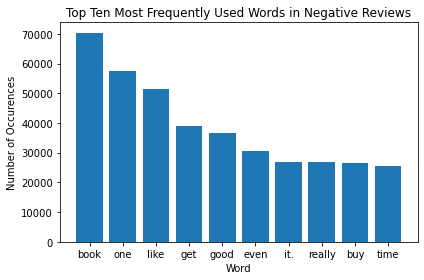

In [21]:
plt.bar([item[0] for item in reviews_neg_key_val_sorted_top_ten], [item[1] for item in reviews_neg_key_val_sorted_top_ten])
plt.xlabel("Word")
plt.ylabel("Number of Occurences")
plt.title("Top Ten Most Frequently Used Words in Negative Reviews")
plt.tight_layout()
plt.show()

# PreProcessing Data

Create a general stemming function

In [22]:
#General function to stem words
def stem_words(words):
    #if there are no words, return an empty list
    if words is None:
        return []
    
    #define a porter stemmer object
    stemmer = PorterStemmer()
    cleaned_stemmed = []
    
    #iterate through all words in review
    for word in words:
        #apply the stemmer object
        stemmed = stemmer.stem(word.lower())
        #add to list of stemmed words
        cleaned_stemmed.append(stemmed)
    
    #return stemmed list
    return cleaned_stemmed

#create spark user defined function for stem_words
stem_udf = udf(stem_words, ArrayType(StringType()))

Apply stemming function to text of reviews

In [23]:
reviews_stemmed = reviews_no_stop_words.withColumn(
    "Title_Stemmed",
    stem_udf(col("`Title (No Stop Words)`"))
).withColumn(
    "Text_Stemmed",
    stem_udf(col("`Text (No Stop Words)`"))
)

Preparing Data for Hugging Face

In [24]:
#Combined stemmed title and text of reviews into one column called text
#Create binary labels where zero is negative sentiment and one is positive sentiment
reviews_for_transformers = reviews_stemmed.withColumn(
    "text",
    concat_ws(" ", 
              array_join(col("Title_Stemmed"), " "),
              array_join(col("Text_Stemmed"), " "))
).withColumn(
    "label",  # Binary label: 0=Negative, 1=Positive
    when(col("Sentiment") == 2, 1).otherwise(0)
).select("text", "label", "Sentiment", "Labeled Sentiment")

Create Train/Validation/Test Split with a 60/20/20 Split

In [25]:
#Split data into train/validation/test set with 60/20/20 split, set random seed for reproduciblity
train_data, valid_data, test_data = reviews_for_transformers.randomSplit([0.6, 0.2, 0.2], seed=42)

#Cache the three data sets
train_data.cache()
valid_data.cache()
test_data.cache()

#Count the records to force computation and caching
train_count = train_data.count()
valid_count = valid_data.count()
test_count = test_data.count()

print("Total Number of Reviews in Training Set: ", train_count)
print("Total Number of Reviews in Validation Set: ", valid_count)
print("Total Number of Reviews in Test Set: ", test_count)

Total Number of Reviews in Training Set:  240349
Total Number of Reviews in Validation Set:  79658
Total Number of Reviews in Test Set:  79967


Save PreProcessed Data to be Accessed later

In [26]:
#Define output path to save preprocessed data to
OUTPUT_PATH = "preprocessed_data_sample"

#Save preprocessed tranining/validation/test data, overwritting what was there before (avoid overwriting errors)
train_data.write.mode("overwrite").parquet(f"{OUTPUT_PATH}/train_transformer_ready")
valid_data.write.mode("overwrite").parquet(f"{OUTPUT_PATH}/valid_transformer_ready")
test_data.write.mode("overwrite").parquet(f"{OUTPUT_PATH}/test_transformer_ready")

#Unpersist in order to free up memory
train_data.unpersist()
valid_data.unpersist()
test_data.unpersist()

#The data can be loaded with
#train_df = spark.read.parquet("preprocessed_data_sample/train_transformer_ready")
#valid_df = ss.read.parquet("preprocessed_data_sample/valid_transformer_ready")
#test_df  = ss.read.parquet("preprocessed_data_sample/test_transformer_ready")

DataFrame[text: string, label: int, Sentiment: int, Labeled Sentiment: string]

# Model Building

Data PreProcessing for Model Building

In [27]:
#read in datasets from saved folder
train_df = ss.read.parquet("preprocessed_data_sample/train_transformer_ready")
valid_df = ss.read.parquet("preprocessed_data_sample/valid_transformer_ready")
test_df  = ss.read.parquet("preprocessed_data_sample/test_transformer_ready")
#cast the labels into doubles, which is necessary for later models
for name in ("train_df","valid_df","test_df"):
    locals()[name] = locals()[name].withColumn("label", col("label").cast("double"))
#create tokenizer
tokenizer = Tokenizer(inputCol="text", outputCol="tokens")
#create hashing object to transform tokenized text into 50,000 term frequency vector
tf  = HashingTF(inputCol="tokens", outputCol="rawFeatures", numFeatures=50_000)
#create inverse document frequency transformer
idf = IDF(inputCol="rawFeatures", outputCol="features")
#create pipeline of data processing with review text being tokenized, transformed into term frequncy vector, then TF-IDF features, fit the preprocessing training data
featurizer = Pipeline(stages=[tokenizer, tf, idf]).fit(train_df)
#transform the traning/validation/test data, repartitioning the resulting dataframe and saving it in memory
train_f = featurizer.transform(train_df).select("features", "label").repartition(1).cache()
valid_f = featurizer.transform(valid_df).select("features", "label").repartition(1).cache()
test_f  = featurizer.transform(test_df).select("features", "label").repartition(1).cache()

Creating a general model training and evaluation function

In [31]:
#General model training function
def evaluate_model(model):
    #fit model on training data
    model = model.fit(train_f)
    #predict label on validation data
    valid_pred = model.transform(valid_f)
    #create evaluators for AUC-PR, AUC-ROC, F1, and Accuracy
    e_aucpr = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderPR")
    e_auc   = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
    e_f1    = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    e_acc   = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    #Evaluate metrics on validation data set
    print("Validation AUC-PR:", e_aucpr.evaluate(valid_pred))
    print("Validation AUC-ROC:", e_auc.evaluate(valid_pred))
    print("Validation F1:", e_f1.evaluate(valid_pred))
    print("Validation Acc:", e_acc.evaluate(valid_pred))
    #get raw decision score from model
    valid_scores = valid_pred.withColumn("raw_score", vector_to_array("rawPrediction")[0])
    #convert to pandas data frame
    pdf = valid_scores.select("label", "raw_score").toPandas()
    #get roc metrics
    fpr, tpr, _ = roc_curve(pdf["label"], pdf["raw_score"])
    #create ROC plot
    plt.figure(figsize=(7, 6))
    plt.plot(tpr, fpr, linewidth=2)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("Validation ROC Curve")
    plt.grid(True)
    plt.show()
    #convert prediction to rdd in tuple form as (prediction, actual label)
    preds_and_labels = valid_pred.select(['prediction', 'label']).rdd.map(tuple)
    #create multiclass metrics object
    metrics = MulticlassMetrics(preds_and_labels)
    #compute confusion matrix
    conf_matrix = metrics.confusionMatrix().toArray()
    #get labels of 0/1 from predictions
    labels = sorted(valid_pred.select('label').distinct().rdd.flatMap(lambda x: x).collect())
    #create data frame of confusion matrix
    df_cm = pd.DataFrame(conf_matrix, index=labels, columns=labels)
    #create heat map confusion matrix plot
    plt.figure(figsize=(8,6))
    sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Validation Confusion Matrix')
    plt.show()

# SVM

Validation AUC-PR: 0.9095010280882236
Validation AUC-ROC: 0.9146881417999527
Validation F1: 0.8408018550878631
Validation Acc: 0.8408069497100102


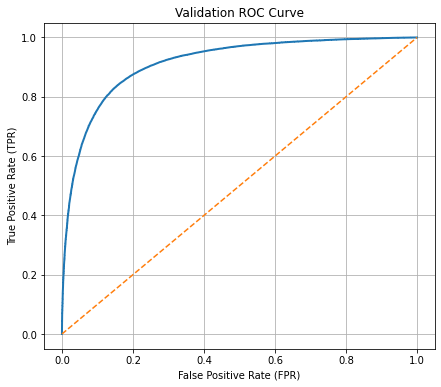

/storage/home/lfm5648/.local/lib/python3.9/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


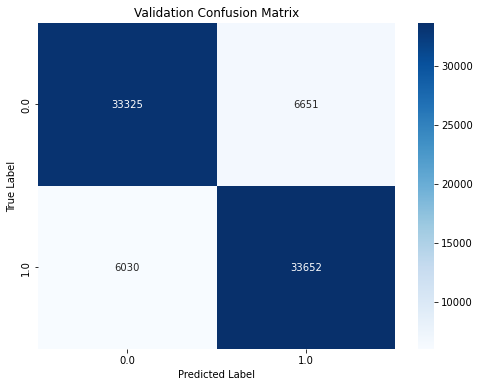

In [32]:
#define Linear SVC model
svm = LinearSVC(featuresCol="features", labelCol="label", maxIter=100, regParam=0.1)
#call evaluate_model function
evaluate_model(svm)

# Decision Tree

In [45]:
#define decision tree
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label", maxDepth=10)
#call evaluate_model function
evaluate_model(dt)

25/12/02 16:44:21 WARN DAGScheduler: Broadcasting large task binary with size 1246.2 KiB
25/12/02 16:44:22 WARN MemoryStore: Not enough space to cache rdd_1494_0 in memory! (computed 273.9 MiB so far)
25/12/02 16:44:22 WARN BlockManager: Persisting block rdd_1494_0 to disk instead.
ERROR:root:KeyboardInterrupt while sending command.                 (0 + 1) / 1]
Traceback (most recent call last):
  File "/storage/home/lfm5648/.local/lib/python3.9/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/storage/home/lfm5648/.local/lib/python3.9/site-packages/py4j/clientserver.py", line 535, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/storage/icds/RISE/sw8/anaconda/anaconda3/lib/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

# Random Forest

In [ ]:
#define random forest model
rf = RandomForestClassifier(
    labelCol="label",
    featuresCol="features",
    numTrees=50,        
    maxDepth=5,        
    featureSubsetStrategy="auto",
)
#call evalaute_model function
evaluate_model(rf)

# Naive Bayes

In [ ]:
#define naive bayes model
nb = NaiveBayes(
    labelCol="label",
    featuresCol="features",
    modelType="multinomial",
    smoothing=1.0
)

#call evaluate_model function
evaluate_model(nb)

# XG Boost

In [ ]:
#find the number of positive/negative reviews
pos = train_f.filter(col("label") == 1.0).count()
neg = train_f.filter(col("label") == 0.0).count()
#get the scale of negatibe to positive reviews
scale_pos_weight = float(neg) / max(float(pos), 1.0)

#define xgboost model
xgb = SparkXGBClassifier(features_col="features",
                         label_col="label",
                         prediction_col="prediction",
                         probability_col="probability",
                         raw_prediction_col="rawPrediction",
                         num_workers=1,
                         tree_method="hist",
                         eval_metric="aucpr",
                         max_depth=6,
                         eta=0.1,
                         subsample=0.8,
                         colsample_bytree=0.8,
                         reg_lambda=1.0,
                         reg_alpha=0.0,
                         scale_pos_weight=scale_pos_weight
)
#call evaluate_model function
#evaluate_model(xgb)

# Hyperparameter Tuning on Linear SVC

25/12/02 18:03:36 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Best hyperparameters:
regParam: 0.013902686711034994
maxIter: 160
tol: 0.0015609194777360274
fitIntercept: True
standardization: False


Best Model Validation AUC-PR: 0.9340474111959773
Best Model Validation AUC-ROC:  0.9366229466272075
Best Model Validation F1: 0.864882070946889
Best Model Validation Acc: 0.8648848828742876


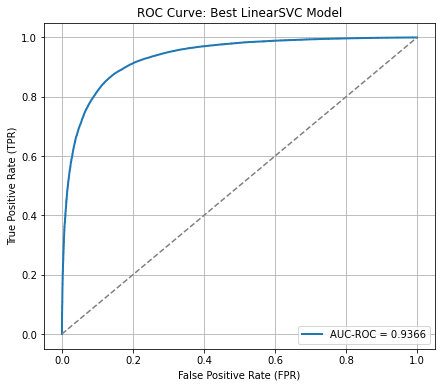

/storage/home/lfm5648/.local/lib/python3.9/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


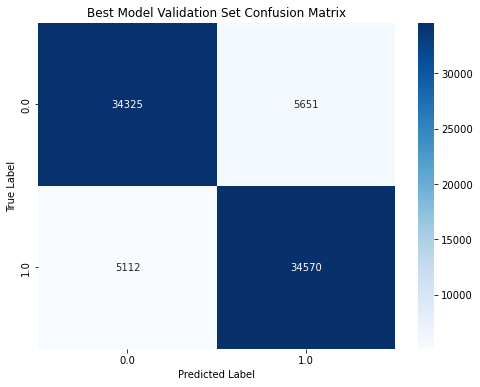

In [29]:
#define linear SVC model
svm_base = LinearSVC(featuresCol="features", labelCol="label")
#define want to train 50 randomly selected model
n_samples = 50
#set random seeds
np.random.seed(42)
random.seed(42)

param_grid = []
#loop through n_samples to randomly select param_grid for each iteration
for _ in range(n_samples):
    #defined parameters grid to sample from
    param_grid.append({
        "regParam": 10**np.random.uniform(-4, 0),
        "maxIter": np.random.randint(1, 21) * 10,
        "tol": 10**np.random.uniform(-6, -2),
        "fitIntercept": bool(np.random.choice([True, False])),
        "standardization": bool(np.random.choice([True, False])),
    })
    
#define AUC-ROC evaluator as going to use AUC-ROC to choose the best hyperparameter tuned model
evaluator_auc = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

results = []
#loop over set of randomly selected parameter settings
for params in param_grid:
    #get copy of svm_base model
    svm = svm_base.copy()
    #set paramters to linear SVC model defined above
    svm = svm.setParams(**params)
    #fit model on training set
    model = svm.fit(train_f)
    #predict on validation set
    pred = model.transform(valid_f)
    #compute AUC-ROC
    auc = evaluator_auc.evaluate(pred)
    #append parameters and AUC-ROC score to results
    results.append({
        "params": params,
        "AUC_ROC": auc
    })

#get best result by AUC-ROC
best_result = max(results, key=lambda x: x["AUC_ROC"])
#output best hyperparameters
print("Best hyperparameters:")
for name, value in best_result["params"].items():
    print(f"{name}: {value}")
#get paramters of best model
best_params = best_result["params"]
#get copy of base svc model
svm = svm_base.copy()
#set best hyperparamters
svm = svm.setParams(**best_params)
#fit best model on training set
best_model = svm.fit(train_f)
#transform validation set with best model
valid_pred = best_model.transform(valid_f)
#create evaluator objects
e_aucpr = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderPR")
e_f1    = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
e_acc   = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
#Evaluate metrics on validation data set
print("Best Model Validation AUC-PR:", e_aucpr.evaluate(valid_pred))
print("Best Model Validation AUC-ROC: ", best_result['AUC_ROC'])
print("Best Model Validation F1:", e_f1.evaluate(valid_pred))
print("Best Model Validation Acc:", e_acc.evaluate(valid_pred))
valid_pred_scores = valid_pred.withColumn("raw_score", vector_to_array("rawPrediction")[0])
#convert predictions to pandas
pdf_valid = valid_pred_scores.select("label", "raw_score").toPandas()
#compute ROC curve
fpr, tpr, _ = roc_curve(pdf_valid["label"], pdf_valid["raw_score"])
#create ROC curve
plt.figure(figsize=(7, 6))
plt.plot(tpr, fpr, linewidth=2, label=f"AUC-ROC = {best_result['AUC_ROC']:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve: Best LinearSVC Model")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#get prediction and acutal labels as tuple rdd in form (prediction, label)
preds_and_labels = valid_pred.select(['prediction', 'label']).rdd.map(tuple)
#create metrics object
metrics = MulticlassMetrics(preds_and_labels)
#create confusion matrix
conf_matrix = metrics.confusionMatrix().toArray()
#get valid labels
labels = sorted(valid_pred.select('label').distinct().rdd.flatMap(lambda x: x).collect())
#create pandas data frame of confusion matrix
df_cm = pd.DataFrame(conf_matrix, index=labels, columns=labels)
#create confusion matrix heat map
plt.figure(figsize=(8,6))
sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Best Model Validation Set Confusion Matrix')
plt.show()

# Evaluation on Test Split

Best Model Test AUC-PR: 0.935312767040635
Best Model Test AUC-ROC: 0.9383888342047538
Best Model Test F1: 0.867193529052549
Best Model Test Acc: 0.8671952180274363


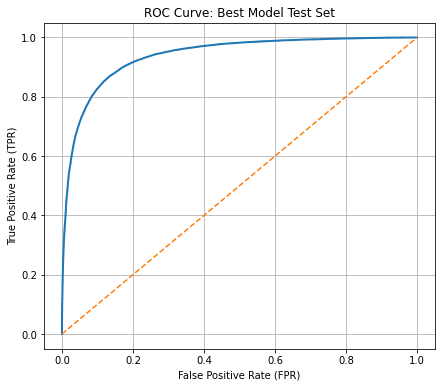

/storage/home/lfm5648/.local/lib/python3.9/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


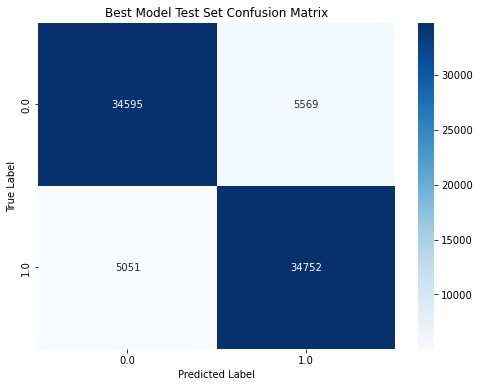

In [30]:
#use best model to predict on test set
test_pred = best_model.transform(test_f)
#create evaluator objects
e_aucpr = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderPR")
e_auc   = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
e_f1    = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
e_acc   = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
#Evaluate metrics on test data set
print("Best Model Test AUC-PR:", e_aucpr.evaluate(test_pred))
print("Best Model Test AUC-ROC:", e_auc.evaluate(test_pred))
print("Best Model Test F1:", e_f1.evaluate(test_pred))
print("Best Model Test Acc:", e_acc.evaluate(test_pred))
#get raw decision score from model
test_scores = test_pred.withColumn("raw_score", vector_to_array("rawPrediction")[0])
#convert to pandas data frame
pdf = test_scores.select("label", "raw_score").toPandas()
#get roc metrics
fpr, tpr, _ = roc_curve(pdf["label"], pdf["raw_score"])
#create ROC plot
plt.figure(figsize=(7, 6))
plt.plot(tpr, fpr, linewidth=2, label=f"AUC-ROC = {e_auc.evaluate(test_pred)}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve: Best Model Test Set")
plt.grid(True)
plt.show()

#get prediction and acutal labels as tuple rdd in form (prediction, label)
preds_and_labels = test_pred.select(['prediction', 'label']).rdd.map(tuple)
#create metrics object
metrics = MulticlassMetrics(preds_and_labels)
#create confusion matrix
conf_matrix = metrics.confusionMatrix().toArray()
#get valid labels
labels = sorted(valid_pred.select('label').distinct().rdd.flatMap(lambda x: x).collect())
#create pandas data frame of confusion matrix
df_cm = pd.DataFrame(conf_matrix, index=labels, columns=labels)
#create confusion matrix heat map
plt.figure(figsize=(8,6))
sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Best Model Test Set Confusion Matrix')
plt.show()